## Make necessary imports

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3, linewidth=200, suppress=True)
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split as train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.metrics as skm
from sklearn import svm
from sklearn.externals import joblib
import os, time
import matplotlib.pyplot as plt
from scipy.misc import toimage
%matplotlib inline

In [3]:
from library.datasets.cifar10 import CIFAR10
from library.utils import file_utils
from library.plot_tools import plot

In [4]:
from sklearn.neural_network import MLPClassifier
from library.hog.hog import HOG

In [5]:
total_time = 0

## Experiment 

In [6]:
exp_no = 1
file_no = 4
data_source = 'Website'
train_validate_split = 0.2
train_validate_split_data = None
num_images_required = 1.0

In [7]:
one_hot = True
make_image = True
mode = 'grey'
scale_method = 'StandardScaler'

In [8]:
block_size = (8,8)
cell_size = (2,2)
nbins = 9

In [9]:
mlp_hidden_size = (3072,3072)
mlp_iterations = 10000
mlp_solver = 'adam'
mlp_alpha = 1e-5

In [10]:
param_name = 'exp_' + str(exp_no).zfill(3) + '_solver_' + mlp_solver
output_directory = '../logs/cifar10/' + str(file_no).zfill(3) + '_mlp_hog/' + 'exp_no_' + str(exp_no).zfill(3) + '/'

## Step 1.1: Load CIFAR 10 Dataset

In [11]:
start = time.time()
cifar10 = CIFAR10(one_hot_encode=one_hot, num_images=num_images_required, make_image=make_image, image_mode=mode,
                  train_validate_split=train_validate_split_data, endian='little')
cifar10.load_data(train=True, test=True, data_directory='./datasets/cifar10/')
end = time.time()
print('[ Step 0] Dataset loaded in %5.6f ms' %((end-start)*1000))
print('Dataset size: ' + str(cifar10.train.data.shape))
num_train_images = cifar10.train.data.shape[0]
total_time += (end-start)

Loading CIFAR 10 Dataset
MD5sum of the file: ./datasets/cifar10/cifar-10.tar.gz is verified
Loading 50000 train images
Loading CIFAR 10 Training Dataset
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_1
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_2
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_3
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_4
Reading unpicked data file: ./datasets/cifar10/cifar-10-batches/data_batch_5
Loading 10000 test images
Loading CIFAR 10 Test Dataset
Unpickling test file: ./datasets/cifar10/cifar-10-batches/test_batch
Reading unpicked test file: ./datasets/cifar10/cifar-10-batches/test_batch
Loaded CIFAR 10 Dataset in 4.2365 seconds
[ Step 0] Dataset loaded in 4237.114191 ms
Dataset size: (50000, 3072)


In [12]:
print('Train data shape:', cifar10.train.data.shape)
if one_hot is True:
    print('Train labels shape:', cifar10.train.one_hot_labels.shape)
if make_image is True:
    print('Train images shape:', cifar10.train.images.shape)
print('Train class labels shape:', cifar10.train.class_labels.shape)
if train_validate_split_data is not None:
    print('Validate data shape:', cifar10.validate.data.shape)
    if one_hot is True:
        print('Validate labels shape:', cifar10.validate.one_hot_labels.shape)
    if make_image is True:
        print('Validate images shape:', cifar10.vaidate.images.shape)
    print('Validate class labels shape:', cifar10.validate.class_labels.shape)
print('Test data shape:', cifar10.test.data.shape)
if one_hot is True:
    print('Test labels shape:', cifar10.test.one_hot_labels.shape)
if make_image is True:
    print('Test images shape:', cifar10.test.images.shape)
print('Test class labels shape:', cifar10.test.class_labels.shape)

Train data shape: (50000, 3072)
Train labels shape: (50000, 10)
Train images shape: (50000, 32, 32)
Train class labels shape: (50000,)
Test data shape: (10000, 3072)
Test labels shape: (10000, 10)
Test images shape: (10000, 32, 32)
Test class labels shape: (10000,)


In [13]:
print('Training images')
print(cifar10.train.data[:5])
if make_image is True and mode=='rgb':
    print('Training images rgb')
    print(cifar10.train.images[:5])
if make_image is True and mode=='float':
    print('Training images float')
    print(cifar10.train.images[:5])
if one_hot is True:
    print('Training labels')
    print(cifar10.train.one_hot_labels[:5])
print('Training classes')
print(cifar10.train.class_labels[:5])
print('Testing images')
print(cifar10.test.data[:5])
if make_image is True and mode=='rgb':
    print('Testing images rgb')
    print(cifar10.test.images[:5])
if make_image is True and mode=='float':
    print('Testing images float')
    print(cifar10.test.images[:5])
if one_hot is True:
    print('Testing labels')
    print(cifar10.test.one_hot_labels[:5])
print('Testing classes')
print(cifar10.test.class_labels[:5])

Training images
[[ 59  43  50 ..., 140  84  72]
 [154 126 105 ..., 139 142 144]
 [255 253 253 ...,  83  83  84]
 [ 28  37  38 ...,  28  37  46]
 [170 168 177 ...,  82  78  80]]
Training labels
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
Training classes
[6 9 9 4 1]
Testing images
[[158 159 165 ..., 124 129 110]
 [235 231 232 ..., 178 191 199]
 [158 158 139 ...,   8   3   7]
 [155 167 176 ...,  50  52  50]
 [ 65  70  48 ..., 136 146 117]]
Testing labels
[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
Testing classes
[3 8 8 0 6]


In [14]:
start = time.time()
data_hog = []
feature_size = 0
hog = HOG(block_size=block_size, cell_size=cell_size, nbins=nbins)
print('Generating HOG features for %d data images' %cifar10.train.images.shape[0])
for fig_num in range(cifar10.train.images.shape[0]):
    img = cifar10.train.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    data_hog.append(gradients.flatten())
    feature_size = gradients.size
data_hog = np.array(data_hog)
print('HOG Features for data: ' + str(data_hog.shape))
end = time.time()
print('Generated HOG for train images in %.6f ms' %((end-start)*1000))

Generating HOG features for 50000 data images
HOG Features for data: (50000, 2304)
Generated HOG for train images in 44370.546818 ms


## Step 1.2: Load CIFAR 10 Test HOG Dataset

In [15]:
start = time.time()
test_hog = []
feature_size = 0
print('Generating HOG features for %d test images' %cifar10.test.images.shape[0])
for fig_num in range(cifar10.test.images.shape[0]):
    img = cifar10.test.images[fig_num, :]
    gradients = hog.make_hog_gradients(img.astype('uint8'))
    test_hog.append(gradients.flatten())
    feature_size = gradients.size
test_hog = np.array(test_hog)
print('HOG Features for test: ' + str(test_hog.shape))
end = time.time()
print('Generated HOG for test images in %.6f ms' %((end-start)*1000))

Generating HOG features for 10000 test images
HOG Features for test: (10000, 2304)
Generated HOG for test images in 8917.975903 ms


Plotting CIFAR 10 Train Dataset


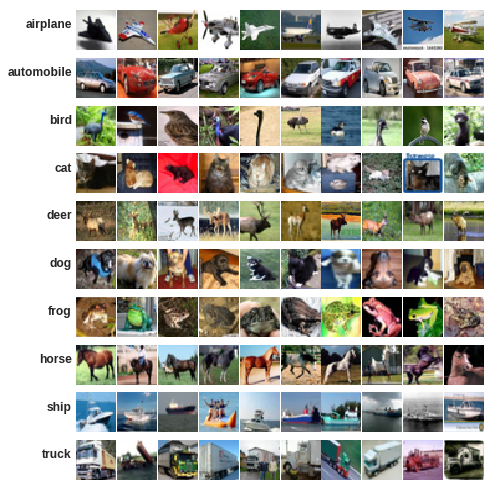

Plotting CIFAR 10 Test Dataset


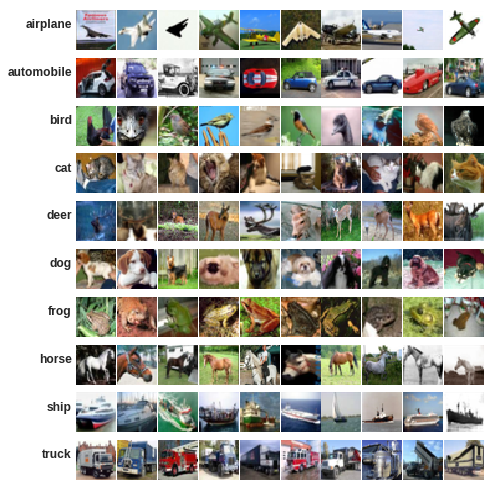

In [16]:
cifar10.plot_sample(plot_data=True, plot_test=True, fig_size=(7, 7))

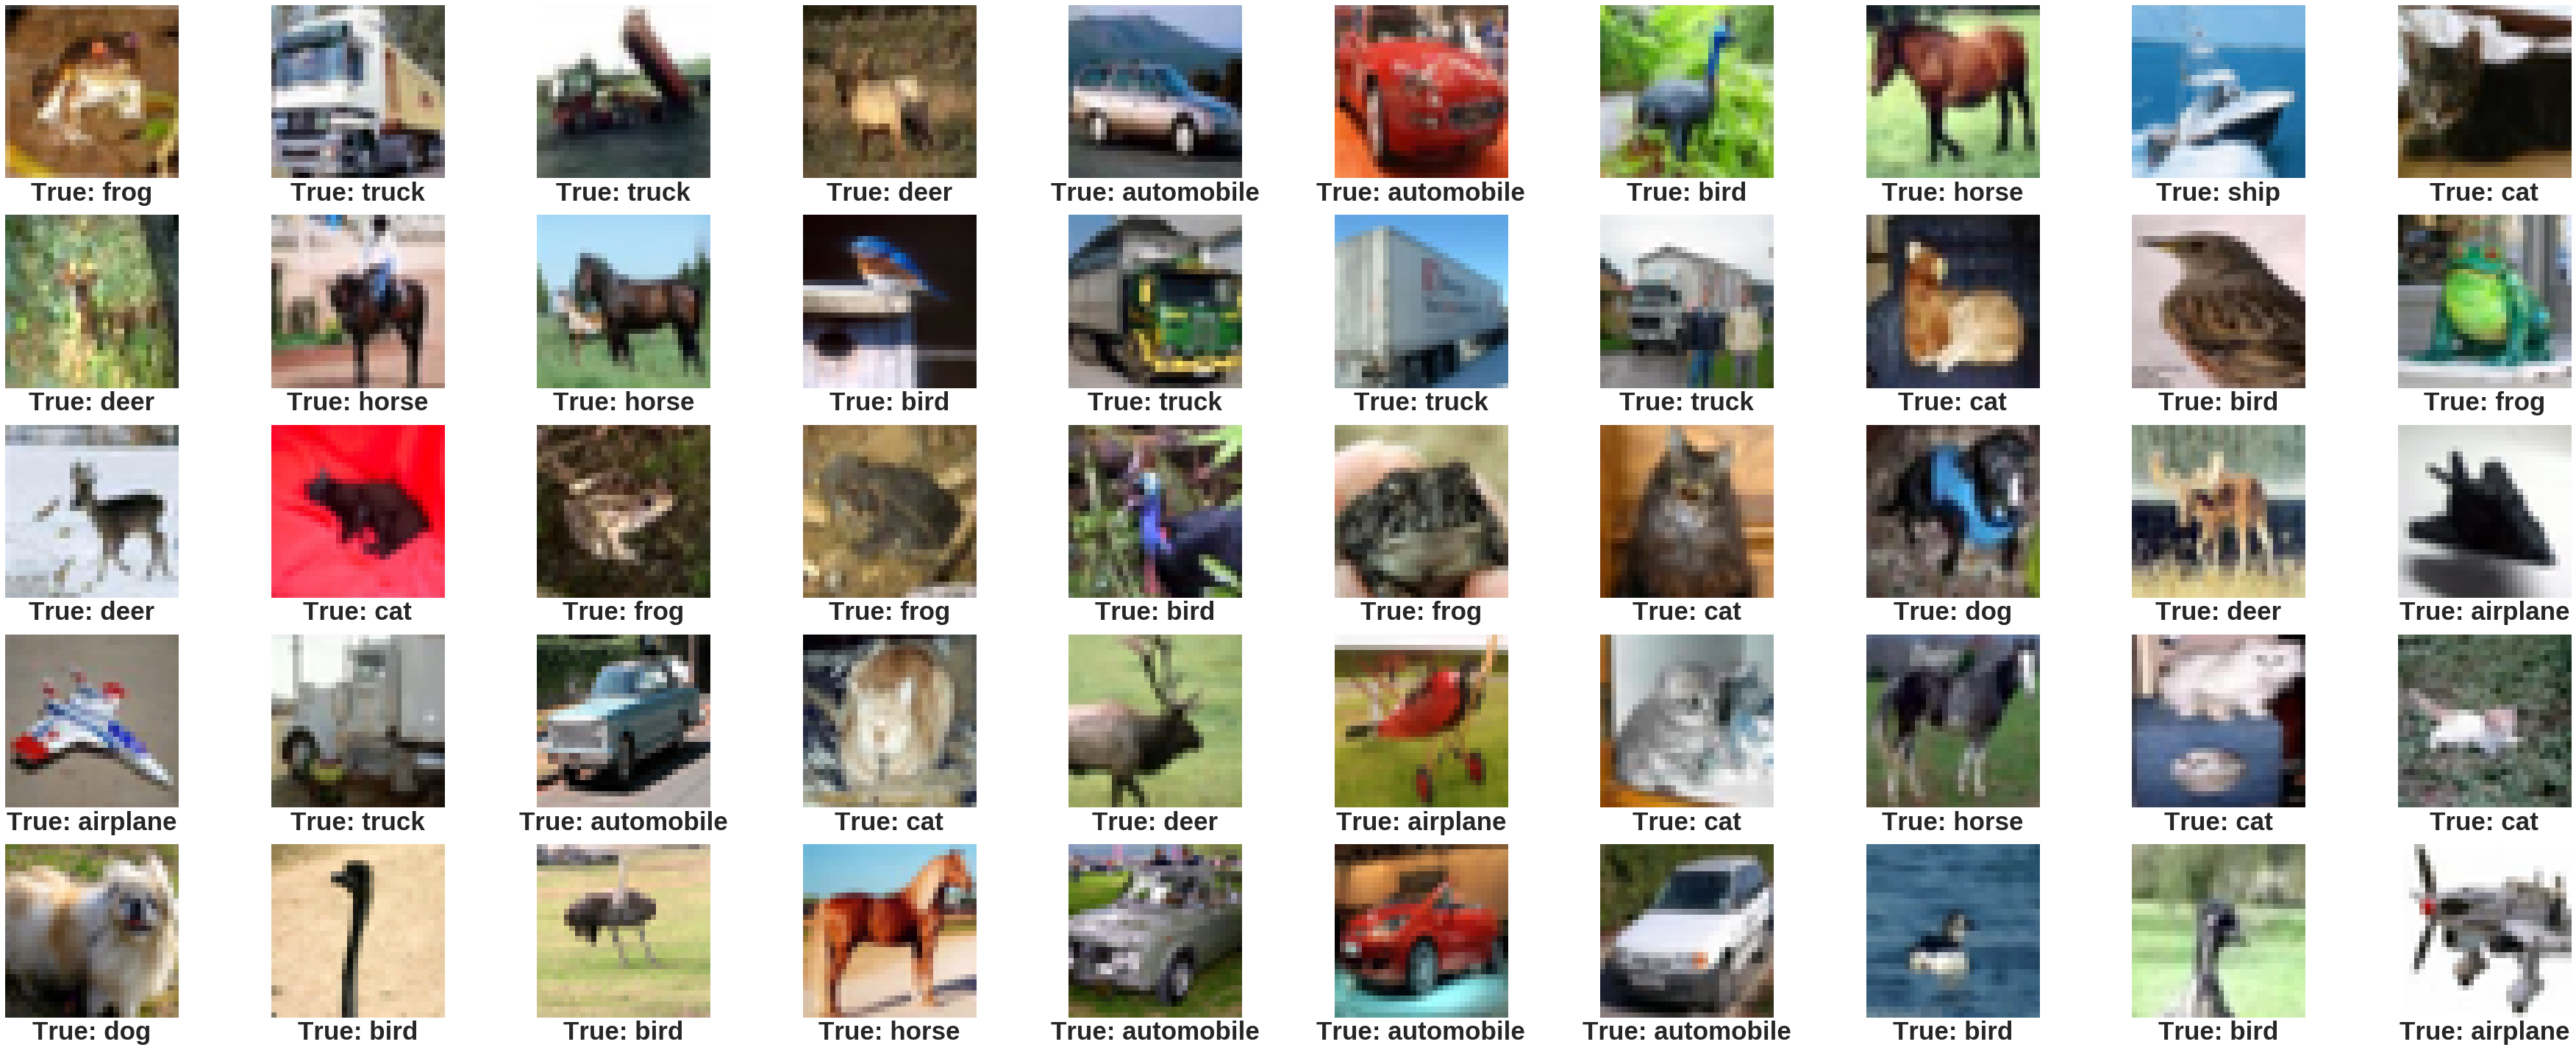

True

In [17]:
cifar10.plot_images(cifar10.train.data[:50, :], cifar10.train.class_names[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=35, convert=True)

## Step 2: Preprocess data

In [18]:
start = time.time()
if scale_method == 'StandardScaler':
    ss = StandardScaler()
elif scale_method == 'MinMaxScaler':
    ss = MinMaxScaler()
else:
    ss = StandardScaler()
data_images = ss.fit_transform(data_hog)
test_images = ss.fit_transform(test_hog)
end = time.time()
print('[ Step 2] Dataset transformations done in %.6f ms' %((end-start)*1000))
print('Training the classifier on %d images' % num_train_images)
print('Dataset size: ' + str(cifar10.train.data.shape))
total_time += (end-start)

[ Step 2] Dataset transformations done in 1949.425459 ms
Training the classifier on 50000 images
Dataset size: (50000, 3072)


## Step 3: Train Test Split of data

In [19]:
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(data_images, cifar10.train.class_labels, 
                                                    test_size=train_validate_split)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
print('Train set shape         : ' + str(X_train.shape))
print('Train labels shape      : ' + str(y_train.shape))
print('Validation set shape    : ' + str(X_test.shape))
print('Validation labels shape : ' + str(y_test.shape))
end = time.time()
print('[ Step 3] Train-test split done in %.6f ms' %((end-start)*1000))
total_time += (end-start)

Train set shape         : (40000, 2304)
Train labels shape      : (40000,)
Validation set shape    : (10000, 2304)
Validation labels shape : (10000,)
[ Step 3] Train-test split done in 438.179493 ms


## Step 4: Initiate Multi Layer Perceptron Classifier

In [ ]:
start = time.time()
clf = MLPClassifier(solver=mlp_solver, alpha=mlp_alpha, hidden_layer_sizes=mlp_hidden_size, random_state=1, 
                    max_iter=mlp_iterations, verbose=True)
print(clf)
end = time.time()
print('[ Step 4] Made the Multi layer perceptron classifier in %.6f ms' %((end-start)*1000))
total_time += (end-start)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3072, 3072), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)
[ Step 4] Made the Multi layer perceptron classifier in 1.444340 ms


## Step 5: Generate the MLP Model using the train data

In [ ]:
start = time.time()
print(X_train.shape)
print(y_train.shape)
clf.fit(X_train, y_train)
end = time.time()
print('[ Step 5] Made the model in %.6f ms' %((end-start)*1000))
total_time += (end-start)

(40000, 2304)
(40000,)
Iteration 1, loss = 1.62911884
Iteration 2, loss = 1.18488842
Iteration 5, loss = 0.83868025
Iteration 6, loss = 0.73630667
Iteration 7, loss = 0.64641569
Iteration 8, loss = 0.56024433
Iteration 9, loss = 0.48184020
Iteration 10, loss = 0.41130267
Iteration 11, loss = 0.37522920
Iteration 12, loss = 0.33412584
Iteration 13, loss = 0.27448947
Iteration 14, loss = 0.26396465
Iteration 15, loss = 0.23709737
Iteration 16, loss = 0.21525058
Iteration 17, loss = 0.21985367
Iteration 18, loss = 0.18734824
Iteration 19, loss = 0.16812963
Iteration 20, loss = 0.16523933
Iteration 21, loss = 0.17369664
Iteration 22, loss = 0.18836781
Iteration 23, loss = 0.17098816
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
[ Step 5] Made the model in 3374930.984497 ms


## Step 6: Write the obtained model to file for further use

In [ ]:
start = time.time()
file_utils.mkdir_p(output_directory)
model_output_path = output_directory + '04_' + param_name + '.pkl'
joblib.dump(clf, model_output_path)
end = time.time()
print('[ Step 6] Write obtained model to %s in %.6f ms' %(model_output_path, ((end-start)*1000)))
total_time += (end-start)

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.


OSError: [Errno 28] No space left on device: '../logs/cifar10/004_mlp_hog'

## Step 7: Do the prediction on validation set

In [ ]:
y_predict = clf.predict(X_test)
labels = sorted(list(set(cifar10.train.class_labels)))
print('Labels: ' + str(labels))
plot.plot_confusion_matrix(y_test, y_predict, classes=cifar10.classes, fig_size=(8,6),
                           normalize=True, title='Confusion matrix for validation set with MLP')
end = time.time()
print('[ Step 7] Make prediction on validation dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

## Step 8: Generate the Classification report for validation data

In [ ]:
start = time.time()
print('Classification report:')
print(skm.classification_report(y_test, y_predict, target_names=cifar10.classes))
validate_accuracy = skm.accuracy_score(y_test, y_predict, normalize=True)
print('Validation accuracy score: ' + str(validate_accuracy))
end = time.time()
print('[ Step 8] Generating classification on validation dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

## Step 9: Generate the predictions on test data set

In [ ]:
start = time.time()
prediction_numbers = clf.predict(test_images)
prediction_classes = []
num_test_images = test_hog.shape[0]
for i in range(num_test_images):
    prediction_classes.append(cifar10.classes[int(prediction_numbers[i])])
end = time.time()
print('[ Step 9] Make prediction on test dataset in %.6f ms' %((end-start)*1000))
total_time += (end-start)

In [ ]:
cifar10.plot_images(cifar10.test.data[:50], cifar10.test.class_names[:50], cls_pred=prediction_classes[:50], 
                    nrows=5, ncols=10, fig_size=(20,50), fontsize=30, convert=True)

## Step 10: Print the accuracy score of the classifier

In [ ]:
start = time.time()
plot.plot_confusion_matrix(cifar10.test.class_labels, prediction_numbers, classes=cifar10.classes,
                           normalize=True, title='Confusion matrix for test set with MLP')
print(skm.classification_report(cifar10.test.class_labels, prediction_numbers, target_names=cifar10.classes))
test_accuracy = skm.accuracy_score(cifar10.test.class_labels, prediction_numbers, normalize=True)
print('Accuracy score on test data: ' + str(test_accuracy))
end = time.time()
total_time += (end-start)

In [ ]:
start = time.time()
print('Prediction done on %d images' %test_images.shape[0])
print('Accuracy of the classifier: %.4f' %clf.score(test_images, cifar10.test.class_labels))
end = time.time()

## Step 11: Write the predictions to CSV file

In [ ]:
start = time.time()
indices = np.arange(1, test_images.shape[0]+1)
predictions = np.column_stack((indices, prediction_classes))
file_utils.mkdir_p(output_directory)
output_csv_file = output_directory + '04_' + param_name + '.csv'
column_names = ['id', 'label']
predict_test_df = pd.DataFrame(data=predictions, columns=column_names)
predict_test_df.to_csv(output_csv_file, index=False)
end = time.time()
print('[ Step 11] Writing the test data to file: %s in %.6f ms' %(output_csv_file, (end-start)*1000))
total_time += (end-start)

In [ ]:
print('Code took %.6f s to run on training with %d examples' % (total_time,num_train_images))

## Print parameters for record

In [ ]:
print('| %d | ' % exp_no, end='')
print('%d | '% num_train_images, end='')
print('Hidden layers size = %s, Max. Iterations: %d, Alpha: %.6f, Solver: %s, Random state: 1 | ' 
      % (str(mlp_hidden_size), mlp_iterations, mlp_alpha, mlp_solver), end='')
print('[Link](%s) | ' % output_csv_file, end='')
print('%.4f | ' % validate_accuracy, end='')
print('%.4f | ' % test_accuracy, end='')
print('%s | ' % data_source, end='')
print('[Link](%s) |' % model_output_path)

## Step 12: Print notebook to HTML file

In [ ]:
def output_HTML(read_file, output_file):
    from nbconvert import HTMLExporter
    import codecs
    import nbformat
    exporter = HTMLExporter()
    output_notebook = nbformat.read(read_file, as_version=4)
    print()
    output, resources = exporter.from_notebook_node(output_notebook)
    codecs.open(output_file, 'w', encoding='utf-8').write(output)

In [ ]:
%%javascript
var notebook = IPython.notebook
notebook.save_notebook()

In [ ]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

In [ ]:
current_file = './' + theNotebook + '.ipynb'
output_file = output_directory + str(file_no).zfill(3) + '_exp_no_' + str(exp_no).zfill(3) + '_' + theNotebook + '.html'
print('Current file: ' + str(current_file))
print('Output file: ' + str(output_file))
file_utils.mkdir_p(output_directory) 
output_HTML(current_file, output_file)

In [ ]:
print('Code took %.6f s to run on training with %d examples' % (total_time,num_train_images))